In [1]:
from SignalTemporalLogic.STLFactory import STLFactory
import matplotlib.pyplot as plt
plt.rc('font', size=12)
import copy
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
import treelib
import re

# warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
#Helper Functions

def loadClientRules(popSize, dataFilename):
    clientRules = []
    clientTrees = []
    num = 1
    clientsAdded = 0
    while clientsAdded < popSize:
        fileName = dataFilename + repr(num) + "Rules.txt"
        fileFound, trees, rls = loadRuleSet(num, fileName)
        # c.logRuleSet()
        if fileFound:
            clientsAdded += 1
            clientTrees.extend(trees)
            clientRules.extend(rls)

        num += 1   
        
    #get nonduplicate list of trees
    currRls = []
    ct = []
    for t in clientTrees:
        strRl = t.toString()
        strRl = re.sub('>=', '>', strRl)
        strRl = re.sub('<=', '<', strRl)

        if strRl not in currRls:
            ct.append(t)
            currRls.append(strRl)
            
    return ct, clientRules


def loadRuleSet(num, textfile):
    ruleSet = []
    ruleTrees = []
    stlFac = STLFactory()
    try:
        file = open(textfile, "r")
        for line in file:
            if line[0] == "(" and line[-2] == ")":
                line = line[1:-2] + "\n"

            rule = stlFac.constructFormulaTree(line)
            rule.getFormulaNoParams()
                
            ruleTrees.append(rule)
            
            #fix relop for string rule
            strRl = rule.toString()
            strRl = re.sub('>=', '>', strRl)
            strRl = re.sub('<=', '<', strRl)
            ruleSet.append(strRl)

        file.close()
        return True, ruleTrees, ruleSet

    except:
        print("File not found for Client %d" % (num) )
        return False, ruleTrees, ruleSet
            


## Load Client Rules

In [3]:
#get list of client rules sorted by count
popSize = 1000
dataFilename = "../Data/ICU/Best/"
# dataFilename = "../Data/Sepsis/Best/"

In [4]:
# Load Client Rule Trees and Text Rule Structures
clientTrees, clientRules = loadClientRules(popSize, dataFilename)

File not found for Client 8
File not found for Client 81
File not found for Client 230
File not found for Client 252
File not found for Client 283
File not found for Client 335
File not found for Client 337
File not found for Client 342
File not found for Client 366
File not found for Client 531
File not found for Client 609
File not found for Client 639
File not found for Client 696
File not found for Client 727
File not found for Client 730
File not found for Client 755
File not found for Client 774
File not found for Client 963
File not found for Client 987
File not found for Client 1018


In [5]:
#Make dataframe of rules and their counts
clientDF = pd.DataFrame.from_dict(dict(Counter(clientRules)), orient='index').reset_index()
clientDF.columns=["Rule", "Rule Count"]
clientDF['Percent of Population'] = clientDF['Rule Count'] / popSize
clientDF = clientDF.sort_values("Rule Count", ascending=False)
clientDF

,Rule,Rule Count,Percent of Population
53,"((MET > 0.000) U[0,0] (death = 0.000))",2669,2.669
57,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",2089,2.089
56,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & CREATINI...",1070,1.070
47,"G[0,0]((hr > 0.000 & Pulse > 0.000))",539,0.539
229,"F[0,0](((af < 0.000 | AF < 0.000) & cosen > 0....",313,0.313
...,...,...,...
11493,"G[0,0]((PLATELET_COUNT < 0.000 -> s24_hr > 0.0...",1,0.001
11491,"G[0,0]((CREATININE < 0.000 | SpO2 < 0.000))",1,0.001
11490,"G[0,0]((death > 0.000 | dfa < 0.000))",1,0.001
11489,"G[0,0]((LOS > 0.000 -> TROPONIN_I > 0.000))",1,0.001


## Load LDP Ruleset

In [6]:
resultsFilename = "../Results/ICU_Ruleset_MCTS_Baseline_1000pop_1000iters.csv"
ldpDF = pd.read_csv(resultsFilename, index_col=0)

ldpTrees = []
ldpRules = []

stlFac = STLFactory()
for r in ldpDF['Rule']:
    rule = stlFac.constructFormulaTree(r + "\n")
    rule.getFormulaNoParams()

    ldpTrees.append(rule)
    ldpRules.append(rule.toString())


ldpDF['Rule'] = ldpRules
ldpDF

,Rule,Percent Count
0,"G[0,0](AST_GOT < 0.000)",0.133333
1,"G[0,0](direct < 0.000)",0.673737
2,"G[0,0](death < 0.000)",0.666667
3,PROTIME_INR > 0.000,0.546512
4,AST_GOT < 0.000,0.243000
...,...,...
179,AF < 0.000,0.701000
180,TOTAL_BILIRUBIN < 0.000,0.278000
181,AST_GOT > 0.000,0.418972
182,MAGNESIUM > 0.000,0.745473


In [7]:
#Get count of the number of true structures matched in client rules

def getTemplateNodes(temp):
    nodes = []
    
    for node in temp.expand_tree(mode=treelib.Tree.DEPTH, sorting=True):
        n = re.sub('[0-9]', '', node)
        nodes.append(n)

    return nodes

def findRuleMatch(template, clientTrees):
    ldpNodes = getTemplateNodes(template)
    ldpVars = template.getAllVars()
    
    
    for c in clientTrees:
        # check if variables in rule
        clVars = c.getAllVars()
        hasVars = True
        for v in ldpVars:
            if v not in clVars:
                hasVars = False

        if hasVars:
            # check for structural match
            clientNodes = []

            for node in c.expand_tree(mode=treelib.Tree.DEPTH, sorting=True):
                n = re.sub('[0-9]', '', node)
                clientNodes.append(n)

            # print("client nodes", clientNodes)
            if nodeListMatch(ldpNodes, clientNodes):
                return True, c.toString()  # found match

    return False, None

# check for match  between two lists of template nodes + client nodes
def nodeListMatch(tempList, cList):
    #Fix relop matches
    tempList[:] = [x if x != "LT" else "LE" for x in tempList]
    tempList[:] = [x if x != "GT" else "GE" for x in tempList]
    cList[:] = [x if x != "LT" else "LE" for x in cList]
    cList[:] = [x if x != "GT" else "GE" for x in cList]

    i = 0
    while i < len(tempList):
        if tempList[i] in cList:
            idx = cList.index(tempList[i]) #get idx of element of cList
            cList = cList[idx+1:]
        else:
            return False

        i = i+1

    return True

def getCoverage(thresh, ldpDF, ldpTrees, clientDF):
    
    #Get client rules above the threshold
    df = clientDF[clientDF['Percent of Population'] >= thresh]
    clientRules = df['Rule'].tolist()
    
    #From client rules, first make client trees
    clientTrees = []
    for c in clientRules:
        c = stlFac.constructFormulaTree(c + "\n")
        clientTrees.append(c)
    
    #Calculate num true rules, num false rules and precision (true rules / total rules found)
    foundRules = 0
    nonRules = 0
    matchLst = []
    
    for l in ldpTrees:
        fnd, cRule = findRuleMatch(l, clientTrees)
        if fnd: #check structural match --> will count partial matches as a full match
            foundRules += 1
            lCount = ldpDF[ldpDF["Rule"] == l.toString()]['Percent Count'].item()
            cCount = clientDF[clientDF["Rule"] == cRule]['Percent of Population'].item()
            matchLst.append([l.toString(), cRule, lCount, cCount])
        else:
            nonRules += 1
            
    
    lst = [len(clientRules), foundRules, nonRules, foundRules / (foundRules + nonRules) ]
    covDF = pd.DataFrame([lst], columns=["Total Client Rules", "Found Rules", "Non Rules", "Precision"]) 
    
    #Make DF that compares the count percentages of the ldp and client rules that were found
    countDF = pd.DataFrame(matchLst, columns=['LDP Rule', 'Client Rule', "LDP Count", "Client Count"])
    
    return covDF, countDF

## Get Coverage of Rules Above Threshold

In [8]:
thresh = 0.05 #Percentage match count

#Get Coverage
covDF, countDF = getCoverage(thresh, ldpDF, ldpTrees, clientDF)
covDF

,Total Client Rules,Found Rules,Non Rules,Precision
0,34,52,132,0.282609


In [9]:
countDF

,LDP Rule,Client Rule,LDP Count,Client Count
0,n_evts > 0.000,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",0.991522,2.089
1,y = 0.000,"((MET > 0.000) U[0,0] (y = 0.000))",1.000000,0.058
2,af > 0.000,"F[0,0](((af < 0.000 | AF < 0.000) & cosen > 0....",0.827354,0.313
3,MET > 0.000,"((MET > 0.000) U[0,0] (death = 0.000))",0.928311,2.669
4,Resp > 0.000,"((Resp > 0.000) U[0,0] (y = 0.000))",0.924586,0.051
5,BLOOD_UREA_NITROGEN > 0.000,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & CREATINI...",0.810662,1.070
6,edrk > 0.000,"((edrk > 0.000) U[0,0] (y = 0.000))",0.923455,0.050
7,dfa > 0.000,"((dfa > 0.000) U[0,0] (y = 0.000))",0.839207,0.050
8,n_evts < 0.000,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",0.956000,2.089
9,Mort > 0.000,"((Mort > 0.000) U[0,0] (y = 0.000))",0.961828,0.053


## Calculate Rules / Query
Found rules / total queries

In [10]:
92 / 50

1.84

In [11]:
clientDF

,Rule,Rule Count,Percent of Population
53,"((MET > 0.000) U[0,0] (death = 0.000))",2669,2.669
57,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",2089,2.089
56,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & CREATINI...",1070,1.070
47,"G[0,0]((hr > 0.000 & Pulse > 0.000))",539,0.539
229,"F[0,0](((af < 0.000 | AF < 0.000) & cosen > 0....",313,0.313
...,...,...,...
11493,"G[0,0]((PLATELET_COUNT < 0.000 -> s24_hr > 0.0...",1,0.001
11491,"G[0,0]((CREATININE < 0.000 | SpO2 < 0.000))",1,0.001
11490,"G[0,0]((death > 0.000 | dfa < 0.000))",1,0.001
11489,"G[0,0]((LOS > 0.000 -> TROPONIN_I > 0.000))",1,0.001


## Calculate Likelihood of Finding Rule given Client Percent count
graph that shows the likelihood of learning a rule vs the # of clients who actually have the rule

In [12]:
from collections import Counter
import operator
cdf = clientDF['Percent of Population']
cdf[cdf>1.0]=1.0
dct = dict(Counter(cdf))
dct = dict(sorted(dct.items(), key=operator.itemgetter(1), reverse=True))
dct

<ipython-input-12-ee9cd7e4d5fb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf[cdf>1.0]=1.0


{0.001: 7998,
 0.002: 3544,
 0.003: 1969,
 0.004: 1264,
 0.005: 884,
 0.006: 611,
 0.007: 506,
 0.008: 374,
 0.009: 243,
 0.01: 173,
 0.011: 124,
 0.012: 100,
 0.013: 87,
 0.014: 76,
 0.015: 59,
 0.017: 51,
 0.016: 49,
 0.019: 42,
 0.023: 34,
 0.021: 32,
 0.02: 32,
 0.018: 30,
 0.022: 29,
 0.027: 26,
 0.024: 26,
 0.028: 19,
 0.025: 16,
 0.03: 14,
 0.026: 13,
 0.033: 12,
 0.043: 11,
 0.032: 11,
 0.046: 10,
 0.044: 10,
 0.051: 9,
 0.05: 9,
 0.048: 8,
 0.045: 8,
 0.037: 8,
 0.031: 8,
 0.029: 8,
 0.04: 7,
 0.038: 7,
 0.049: 6,
 0.042: 6,
 0.034: 6,
 0.035: 5,
 0.047: 4,
 0.036: 4,
 1.0: 3,
 0.056: 3,
 0.053: 3,
 0.039: 3,
 0.054: 2,
 0.041: 2,
 0.539: 1,
 0.313: 1,
 0.058: 1,
 0.057: 1,
 0.052: 1}

In [13]:
ldf = ldpDF['Percent Count']
ldf[ldf>1.0]=1.0
ldf = ldf.round(2)

lct = dict(Counter(ldf))
lct = dict(sorted(lct.items(), key=operator.itemgetter(1), reverse=True))
lct

<ipython-input-13-7a1f587f99c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf[ldf>1.0]=1.0


{0.61: 7,
 0.55: 6,
 0.44: 6,
 0.13: 5,
 0.48: 5,
 0.93: 5,
 0.96: 4,
 0.84: 4,
 0.75: 4,
 0.56: 4,
 0.5: 4,
 0.67: 3,
 0.98: 3,
 0.83: 3,
 0.71: 3,
 0.88: 3,
 0.92: 3,
 0.81: 3,
 0.54: 3,
 0.28: 3,
 0.1: 3,
 0.9: 3,
 0.77: 3,
 0.45: 3,
 0.85: 3,
 0.74: 3,
 0.66: 3,
 0.8: 3,
 0.25: 3,
 0.97: 3,
 0.41: 2,
 0.16: 2,
 1.0: 2,
 0.3: 2,
 0.01: 2,
 0.27: 2,
 0.91: 2,
 0.64: 2,
 0.15: 2,
 0.51: 2,
 0.62: 2,
 0.32: 2,
 0.35: 2,
 0.14: 2,
 0.33: 2,
 0.58: 2,
 0.78: 2,
 0.82: 2,
 0.73: 2,
 0.42: 2,
 0.52: 2,
 0.59: 2,
 0.4: 2,
 0.24: 1,
 0.99: 1,
 0.04: 1,
 0.6: 1,
 0.76: 1,
 0.89: 1,
 0.36: 1,
 0.53: 1,
 0.11: 1,
 0.39: 1,
 0.69: 1,
 0.95: 1,
 0.57: 1,
 0.49: 1,
 0.22: 1,
 0.79: 1,
 0.47: 1,
 0.86: 1,
 0.17: 1,
 0.26: 1,
 0.87: 1,
 0.03: 1,
 0.43: 1,
 0.65: 1,
 0.63: 1,
 0.68: 1,
 0.7: 1}

Text(0.5, 0, 'Fraction of Clients')

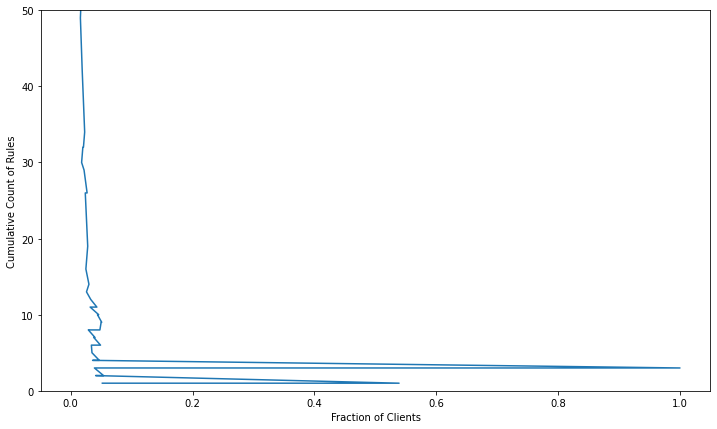

In [14]:

plt.figure(figsize=(12,7))
# plt.xscale('log')
# plt.yscale('log')
plt.plot(dct.keys(), dct.values(), label='Client')
# plt.plot(lct.keys(), lct.values(), label='LDP Baseline')
plt.ylim([0, 50])
plt.ylabel("Cumulative Count of Rules")
plt.xlabel("Fraction of Clients")

In [15]:
LL = np.sum(stats.norm.logpdf(y, pred, std_dev))

NameError: name 'stats' is not defined

In [ ]:
clientDF

In [ ]:
#Might need to add the rules in clientDF that arent in the countDF --> for ldp count those would have 0


In [ ]:
# countDF = countDF.sort_values("Client Count", ascending=False)
cdf = clientDF['Percent of Population']
cdf[cdf>1.0]=1.0
cdf

In [ ]:
countDF = countDF.sort_values("Client Count", ascending=False)
df = countDF['Client Count']
df[df>1.0]=1.0
df

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, '.', label = 'Client')
plt.plot(df.values, '.', label = 'LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Baseline Comparison of Found STL Structures")
plt.legend()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, label = 'Client Rule Structures')
# plt.plot(df.values, '.', label = 'LDP')
plt.vlines(x=490, ymin=0, ymax=1.0, colors='red', ls=':', lw=2, label='Learned By LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Rules Found by LDP")
plt.legend()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf-df)
plt.xlabel("Rule Number")
plt.ylabel("Error Percentage")
plt.title("Error Calculation of Found STL Structures")
# plt.legend()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, '.', label = 'Client')
plt.plot(df.values, '.', label = 'LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Baseline Comparison of Found STL Structures")
plt.legend()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, label = 'Client Rule Structures')
# plt.plot(df.values, '.', label = 'LDP')
plt.vlines(x=490, ymin=0, ymax=1.0, colors='red', ls=':', lw=2, label='Learned By LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Rules Found by LDP")
plt.legend()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(cdf-df)
plt.xlabel("Rule Number")
plt.ylabel("Error Percentage")
plt.title("Error Calculation of Found STL Structures")
# plt.legend()